In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/Coconut'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
tifs = tifs[:5]

In [5]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [6]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo-Coconut', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-Full-Demo-Coconut already exists
Loading job directory for Full-Demo-Coconut in /mnt/md0/runs
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [10]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = 200

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 70
job.params['fuse_shift_override'] = 1

   Saved a copy of params at /mnt/md0/runs/s3d-Full-Demo-Coconut/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/summary.npy
Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


Loaded 1 files, total 18.79 GB
   Selecting 200 random frames from the init tif files
   Loaded movie with 200 frames and shape 30, 584, 584
         Enforcing positivity in mean image


/home/ali/packages/s2p-lbm/suite3d/utils.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/crosstalk_plots
saved
Close figure


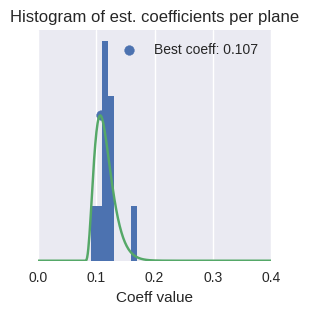

   Subtracting with estimated coefficient 0.107
         Subtracting plane 0 from 15
         Subtracting plane 1 from 16
         Subtracting plane 2 from 17
         Subtracting plane 3 from 18
         Subtracting plane 4 from 19
         Subtracting plane 5 from 20
         Subtracting plane 6 from 21
         Subtracting plane 7 from 22
         Subtracting plane 8 from 23
         Subtracting plane 9 from 24
         Subtracting plane 10 from 25
         Subtracting plane 11 from 26
         Subtracting plane 12 from 27
         Subtracting plane 13 from 28
         Subtracting plane 14 from 29
   Estimating fusing shifts


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


      Overriding
   Using best fuse shift of 1
   Building ops file
   Saved init mov to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/init_mov.npy
   Aligning planes
float64
20
      Fixing plane alignment outliers
   Fusing and padding init mov
Setting smooth_sigma: 1.15
Setting maxregshift: 0.15
Setting Ly: 709
Setting Lx: 671
Setting nonrigid: True
   Computing reference images
        Computed reference for plane 0
        Computed reference for plane 1
        Computed reference for plane 2
        Computed reference for plane 3
        Computed reference for plane 4
        Computed reference for plane 5
        Computed reference for plane 6
        Computed reference for plane 7
        Computed reference for plane 8
        Computed reference for plane 9
        Computed reference for plane 10
        Computed reference for plane 11
        Computed reference for plane 12
        Computed reference for plane 13
        Computed reference for plane 14
        Computed reference 

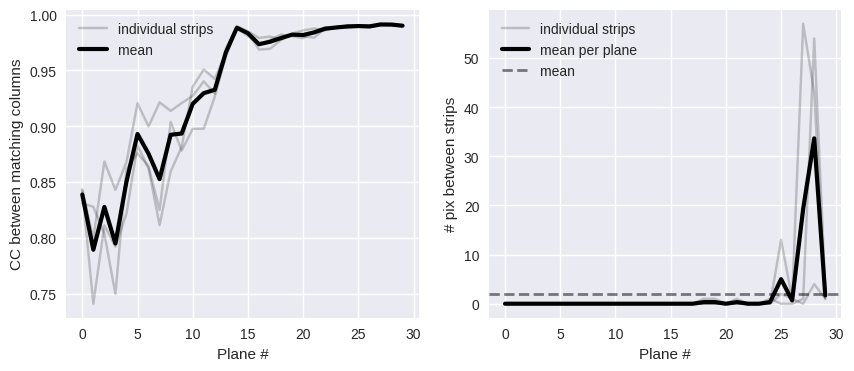

In [25]:
%%time
# This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# soon this will also be gpu-ified to be faster!
job.run_init_pass()

In [26]:
summary = job.load_summary()

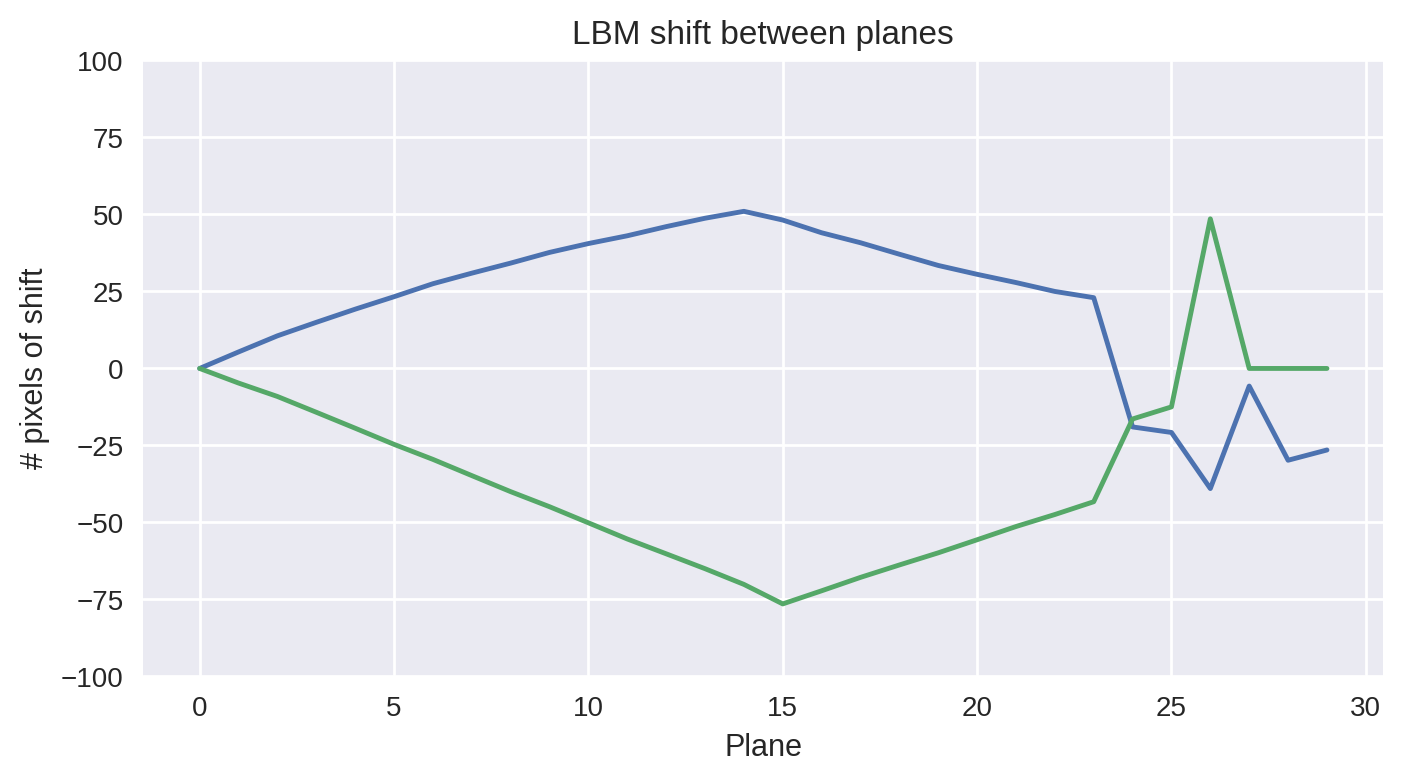

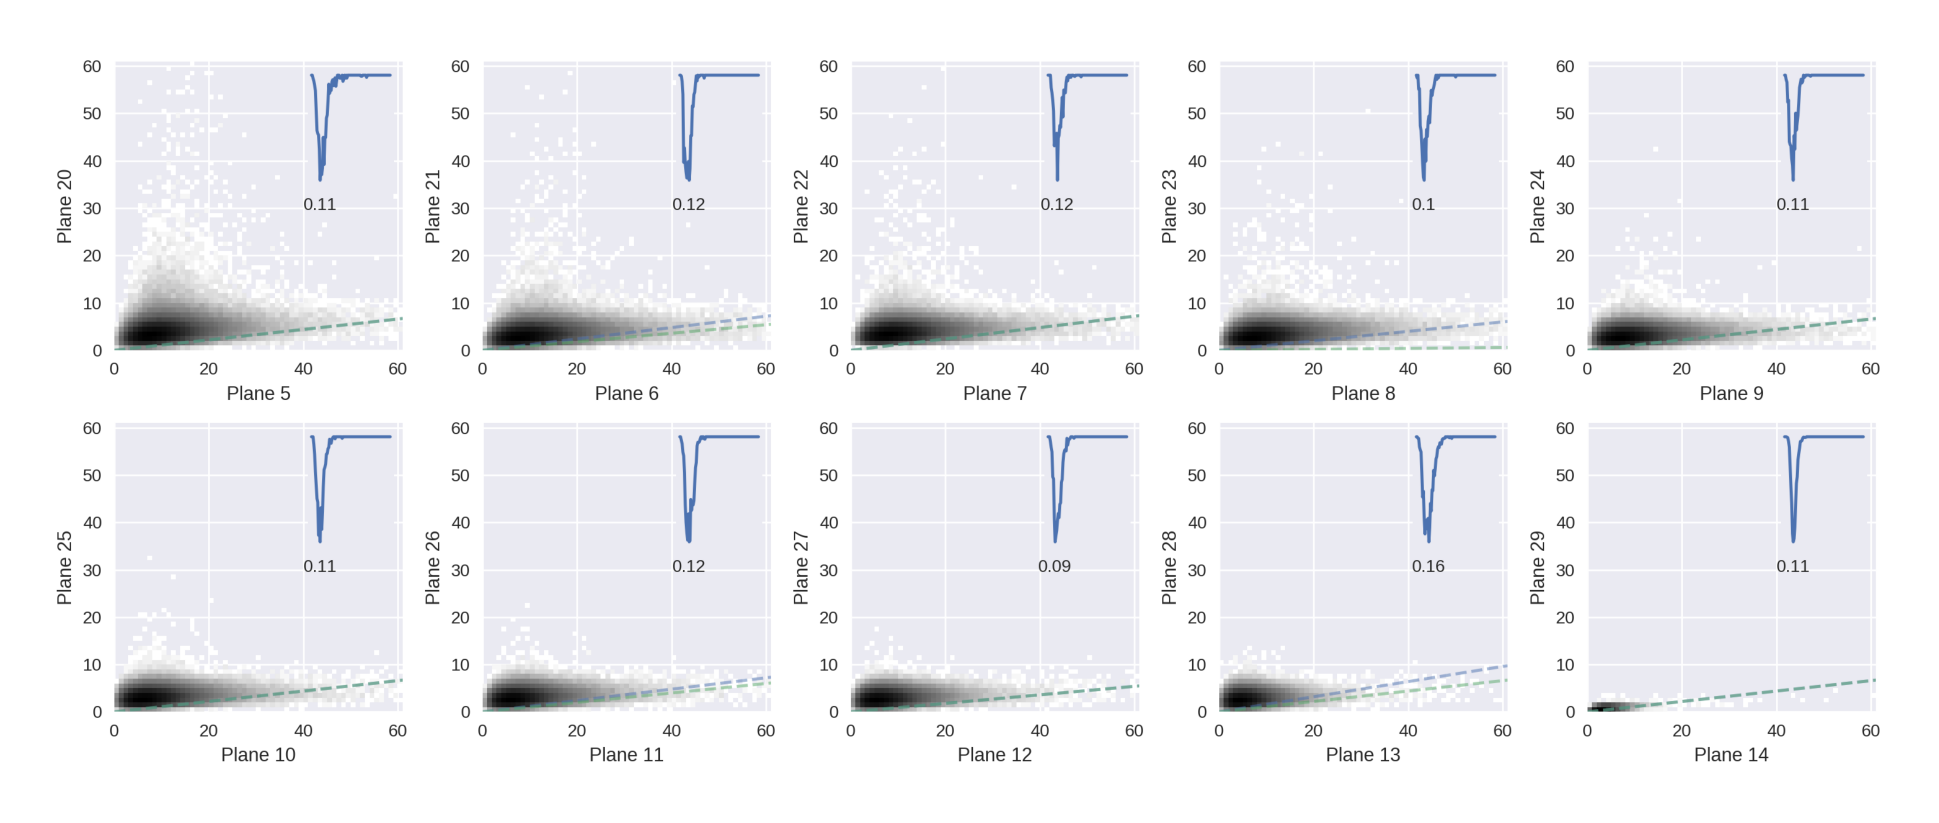

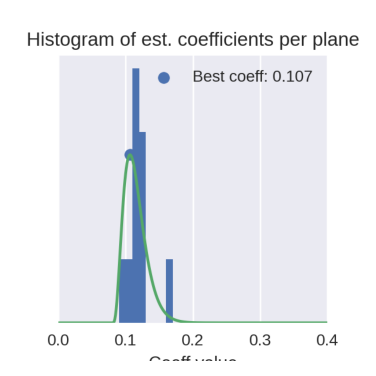

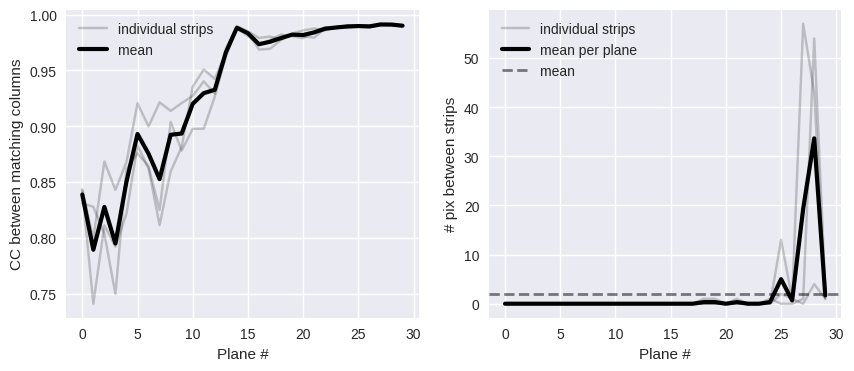

In [27]:
job.show_summary_plots()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [11]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
job.params['gpu_reg_batchsize'] = 10

In [12]:
%%time
job.register_gpu()

      Found dir /mnt/md0/runs/s3d-Full-Demo-Coconut/registered_fused_data with tag registered_fused_data
Will analyze 5 tifs in 5 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 150.698 GB, Virtual Available: 368.129 GB, Virtual Used: 135.067 GB, Swap Used: 015.631 GB
Loading Batch 0 of 4
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in a

   Loaded 1 files, total 18.79 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 169.460 GB, Virtual Available: 349.367 GB, Virtual Used: 153.828 GB, Swap Used: 015.631 GB
         Memory after movie copied from threadTotal Used: 188.292 GB, Virtual Available: 330.535 GB, Virtual Used: 172.661 GB, Swap Used: 015.631 GB
         Memory after thread memory clearedTotal Used: 169.462 GB, Virtual Available: 349.365 GB, Virtual Used: 153.831 GB, Swap Used: 015.631 GB
   Launching IO thread for next batch
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00002.tif
         After IO thread launch:Total Used: 169.462 GB, Virtual Available: 349.365 GB, Virtual Used: 153.831 GB, Swap Used: 015.631 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.52 sec
         Subtracting min pix vals to enforce positivity
       

   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 194.697 GB, Virtual Available: 324.131 GB, Virtual Used: 179.065 GB, Swap Used: 015.631 GB
      Sending frames 70-80 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec

<tifffile.TiffFile 'Max30_500umdeep…_00001_00002.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 198.288 GB, Virtual Available: 320.539 GB, Virtual Used: 182.657 GB, Swap Used: 015.631 GB
      Sending frames 80-90 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 4.48 sec
         After GPU Batch:    Total Used: 231.805 GB, Virtual Available: 287.023 GB, Virtual Used: 216.173 GB, Swap Used: 015.631 GB
      Sending frames 140-150 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.19 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.35 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.62 s

   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 240.681 GB, Virtual Available: 278.147 GB, Virtual Used: 225.049 GB, Swap Used: 015.631 GB
      Sending frames 220-230 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 208.384 GB, Virtual Available: 310.444 GB, Virtual Used: 192.752 GB, Swap Used: 015.631 GB
      Sending frames 300-310 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 212.664 GB, Virtual Available: 306.163 GB, Virtual Used: 197.033 GB, Swap Used: 015.631 GB
      Sending frames 380-390 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 216.911 GB, Virtual Available: 301.917 GB, Virtual Used: 201.279 GB, Swap Used: 015.631 GB
      Sending frames 460-470 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 221.168 GB, Virtual Available: 297.659 GB, Virtual Used: 205.537 GB, Swap Used: 015.631 GB
      Sending frames 540-550 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 225.436 GB, Virtual Available: 293.392 GB, Virtual Used: 209.804 GB, Swap Used: 015.631 GB
      Sending frames 620-630 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 229.702 GB, Virtual Available: 289.125 GB, Virtual Used: 214.070 GB, Swap Used: 015.631 GB
      Sending frames 700-710 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 234.080 GB, Virtual Available: 284.747 GB, Virtual Used: 218.449 GB, Swap Used: 015.631 GB
      Sending frames 780-790 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.04 sec
         After GPU Batch:    Total Used: 238.317 GB, Virtual Available: 280.511 GB, Virtual Used: 222.685 GB, Swap Used: 015.631 GB
      Sending frames 860-870 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.13 sec
   Non rigid transformed (on CPU) in 1.02 sec
         After GPU Batch:    Total Used: 242.633 GB, Virtual Available: 276.195 GB, Virtual Used: 227.001 GB, Swap Used: 015.631 GB
      Sending frames 940-950 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Memory after movie copied from threadTotal Used: 245.501 GB, Virtual Available: 273.327 GB, Virtual Used: 229.869 GB, Swap Used: 015.631 GB
         Memory after thread memory clearedTotal Used: 226.669 GB, Virtual Available: 292.158 GB, Virtual Used: 211.038 GB, Swap Used: 015.631 GB
   Launching IO thread for next batch
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00003.tif
         After IO thread launch:Total Used: 226.669 GB, Virtual Available: 292.158 GB, Virtual Used: 211.038 GB, Swap Used: 015.631 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shi

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.01 sec
         After GPU Batch:    Total Used: 248.652 GB, Virtual Available: 270.175 GB, Virtual Used: 233.021 GB, Swap Used: 015.631 GB
      Sending frames 80-90 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of

<tifffile.TiffFile 'Max30_500umdeep…_00001_00003.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 252.298 GB, Virtual Available: 266.530 GB, Virtual Used: 236.666 GB, Swap Used: 015.631 GB
      Sending frames 90-100 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 9.90 sec
         After GPU Batch:    Total Used: 284.059 GB, Virtual Available: 234.768 GB, Virtual Used: 268.428 GB, Swap Used: 015.631 GB
      Sending frames 150-160 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.35 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 s

   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.15 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 292.527 GB, Virtual Available: 226.300 GB, Virtual Used: 276.896 GB, Swap Used: 015.631 GB
      Sending frames 230-240 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 262.062 GB, Virtual Available: 256.765 GB, Virtual Used: 246.430 GB, Swap Used: 015.631 GB
      Sending frames 310-320 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 266.350 GB, Virtual Available: 252.477 GB, Virtual Used: 250.719 GB, Swap Used: 015.631 GB
      Sending frames 390-400 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 270.566 GB, Virtual Available: 248.261 GB, Virtual Used: 254.935 GB, Swap Used: 015.631 GB
      Sending frames 470-480 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 274.839 GB, Virtual Available: 243.988 GB, Virtual Used: 259.208 GB, Swap Used: 015.631 GB
      Sending frames 550-560 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 279.081 GB, Virtual Available: 239.746 GB, Virtual Used: 263.450 GB, Swap Used: 015.631 GB
      Sending frames 630-640 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 283.334 GB, Virtual Available: 235.493 GB, Virtual Used: 267.702 GB, Swap Used: 015.631 GB
      Sending frames 710-720 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.02 sec
         After GPU Batch:    Total Used: 287.599 GB, Virtual Available: 231.228 GB, Virtual Used: 271.968 GB, Swap Used: 015.631 GB
      Sending frames 790-800 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 291.861 GB, Virtual Available: 226.966 GB, Virtual Used: 276.230 GB, Swap Used: 015.631 GB
      Sending frames 870-880 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 296.194 GB, Virtual Available: 222.633 GB, Virtual Used: 280.563 GB, Swap Used: 015.631 GB
      Sending frames 950-960 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
      Allocated array of shape (30, 986, 709, 671) to store CPU movie
         After array alloc:  Total Used: 226.920 GB, Virtual Available: 291.907 GB, Virtual Used: 211.289 GB, Swap Used: 015.631 GB
   Non rigid transformed (on CPU) in 1.04 sec
         After GPU Batch:    Total Used: 227.289 GB, Virtual Available: 291.539 GB, Virtual Used: 211.657 GB, Swap Used: 015.631 GB
      Sending frames 10-20 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting cross

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec


<tifffile.TiffFile 'Max30_500umdeep…_00001_00004.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 252.752 GB, Virtual Available: 266.075 GB, Virtual Used: 237.121 GB, Swap Used: 015.631 GB
      Sending frames 90-100 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 11.82 sec
         After GPU Batch:    Total Used: 319.383 GB, Virtual Available: 199.444 GB, Virtual Used: 303.752 GB, Swap Used: 015.631 GB
      Sending frames 150-160 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 2.72 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 2.89 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 3.13 

   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.40 sec
   Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 261.639 GB, Virtual Available: 257.188 GB, Virtual Used: 246.008 GB, Swap Used: 015.631 GB
      Sending frames 230-240 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 261.977 GB, Virtual Available: 256.850 GB, Virtual Used: 246.346 GB, Swap Used: 015.631 GB
      Sending frames 310-320 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 266.243 GB, Virtual Available: 252.584 GB, Virtual Used: 250.612 GB, Swap Used: 015.631 GB
      Sending frames 390-400 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 270.505 GB, Virtual Available: 248.322 GB, Virtual Used: 254.874 GB, Swap Used: 015.631 GB
      Sending frames 470-480 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.04 sec
         After GPU Batch:    Total Used: 274.772 GB, Virtual Available: 244.056 GB, Virtual Used: 259.140 GB, Swap Used: 015.631 GB
      Sending frames 550-560 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 279.044 GB, Virtual Available: 239.783 GB, Virtual Used: 263.413 GB, Swap Used: 015.631 GB
      Sending frames 630-640 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 283.319 GB, Virtual Available: 235.508 GB, Virtual Used: 267.688 GB, Swap Used: 015.631 GB
      Sending frames 710-720 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 287.566 GB, Virtual Available: 231.261 GB, Virtual Used: 271.935 GB, Swap Used: 015.631 GB
      Sending frames 790-800 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 291.868 GB, Virtual Available: 226.960 GB, Virtual Used: 276.236 GB, Swap Used: 015.631 GB
      Sending frames 870-880 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 296.148 GB, Virtual Available: 222.679 GB, Virtual Used: 280.517 GB, Swap Used: 015.631 GB
      Sending frames 950-960 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
      Allocated array of shape (30, 986, 709, 671) to store CPU movie
         After array alloc:  Total Used: 226.686 GB, Virtual Available: 292.141 GB, Virtual Used: 211.055 GB, Swap Used: 015.631 GB
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 227.087 GB, Virtual Available: 291.740 GB, Virtual Used: 211.456 GB, Swap Used: 015.631 GB
      Sending frames 10-20 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting cross

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec


<tifffile.TiffFile 'Max30_500umdeep…_00001_00005.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 252.123 GB, Virtual Available: 266.704 GB, Virtual Used: 236.492 GB, Swap Used: 015.631 GB
      Sending frames 90-100 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 14.31 sec
         After GPU Batch:    Total Used: 312.377 GB, Virtual Available: 206.505 GB, Virtual Used: 296.691 GB, Swap Used: 015.686 GB
      Sending frames 140-150 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 2.78 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 2.95 sec
         Allocated GPU array for non-rigid reg in 0.11 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 3.21 

   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.15 sec
   Non rigid transformed (on CPU) in 1.53 sec
         After GPU Batch:    Total Used: 260.855 GB, Virtual Available: 258.026 GB, Virtual Used: 245.170 GB, Swap Used: 015.686 GB
      Sending frames 220-230 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 261.279 GB, Virtual Available: 257.603 GB, Virtual Used: 245.593 GB, Swap Used: 015.686 GB
      Sending frames 300-310 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 265.545 GB, Virtual Available: 253.337 GB, Virtual Used: 249.859 GB, Swap Used: 015.686 GB
      Sending frames 380-390 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 269.817 GB, Virtual Available: 249.065 GB, Virtual Used: 254.131 GB, Swap Used: 015.686 GB
      Sending frames 460-470 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 274.090 GB, Virtual Available: 244.792 GB, Virtual Used: 258.404 GB, Swap Used: 015.686 GB
      Sending frames 540-550 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 278.358 GB, Virtual Available: 240.524 GB, Virtual Used: 262.672 GB, Swap Used: 015.686 GB
      Sending frames 620-630 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 282.658 GB, Virtual Available: 236.223 GB, Virtual Used: 266.973 GB, Swap Used: 015.686 GB
      Sending frames 700-710 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.04 sec
         After GPU Batch:    Total Used: 286.908 GB, Virtual Available: 231.973 GB, Virtual Used: 271.223 GB, Swap Used: 015.686 GB
      Sending frames 780-790 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.04 sec
         After GPU Batch:    Total Used: 291.188 GB, Virtual Available: 227.694 GB, Virtual Used: 275.502 GB, Swap Used: 015.686 GB
      Sending frames 860-870 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.13 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 295.458 GB, Virtual Available: 223.423 GB, Virtual Used: 279.773 GB, Swap Used: 015.686 GB
      Sending frames 940-950 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Memory after movie copied from threadTotal Used: 245.145 GB, Virtual Available: 273.737 GB, Virtual Used: 229.459 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 226.317 GB, Virtual Available: 292.565 GB, Virtual Used: 210.631 GB, Swap Used: 015.686 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 709, 671; 1.06 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase corr

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 230.756 GB, Virtual Available: 288.125 GB, Virtual Used: 215.071 GB, Swap Used: 015.686 GB
      Sending frames 80-90 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 235.034 GB, Virtual Available: 283.847 GB, Virtual Used: 219.349 GB, Swap Used: 015.686 GB
      Sending frames 160-170 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 239.299 GB, Virtual Available: 279.583 GB, Virtual Used: 223.613 GB, Swap Used: 015.686 GB
      Sending frames 240-250 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.13 sec
   Non rigid transformed (on CPU) in 1.07 sec
         After GPU Batch:    Total Used: 243.563 GB, Virtual Available: 275.319 GB, Virtual Used: 227.877 GB, Swap Used: 015.686 GB
      Sending frames 320-330 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 247.823 GB, Virtual Available: 271.059 GB, Virtual Used: 232.137 GB, Swap Used: 015.686 GB
      Sending frames 400-410 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.03 sec
         After GPU Batch:    Total Used: 252.099 GB, Virtual Available: 266.783 GB, Virtual Used: 236.413 GB, Swap Used: 015.686 GB
      Sending frames 480-490 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 256.363 GB, Virtual Available: 262.518 GB, Virtual Used: 240.678 GB, Swap Used: 015.686 GB
      Sending frames 560-570 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.31 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 260.626 GB, Virtual Available: 258.256 GB, Virtual Used: 244.940 GB, Swap Used: 015.686 GB
      Sending frames 640-650 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.00 sec
         After GPU Batch:    Total Used: 264.944 GB, Virtual Available: 253.937 GB, Virtual Used: 249.259 GB, Swap Used: 015.685 GB
      Sending frames 720-730 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.57 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 269.204 GB, Virtual Available: 249.677 GB, Virtual Used: 253.519 GB, Swap Used: 015.685 GB
      Sending frames 800-810 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.55 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.06 sec
         After GPU Batch:    Total Used: 273.461 GB, Virtual Available: 245.420 GB, Virtual Used: 257.776 GB, Swap Used: 015.685 GB
      Sending frames 880-890 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.15 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 709, 671) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 277.739 GB, Virtual Available: 241.143 GB, Virtual Used: 262.053 GB, Swap Used: 015.685 GB
      Sending frames 960-970 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

In [13]:
mov_full = job.get_registered_movie('registered_fused_data','f')
im_full = mov_full.mean(axis=1).compute()

In [14]:
# find crop values that minimize dark zones - check planes 0 and 15 in the following cell to 
# make sure you're not cutting out parts of the brain
crop = ((0,18), (100,500), (100, 500))

(-0.5, 399.5, 399.5, -0.5)

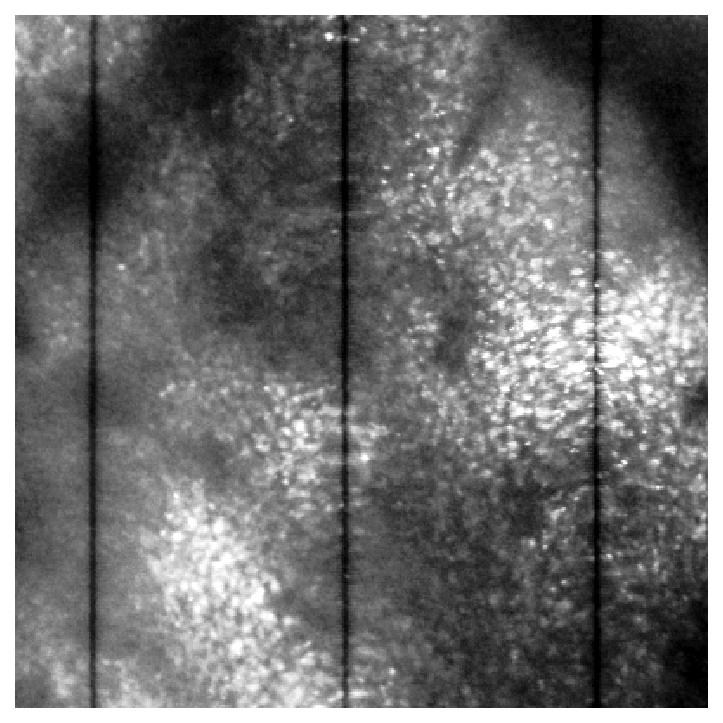

In [15]:
f,ax,__  = tfu.show_tif(im_full[0,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [18]:
job.logfile

'/mnt/md0/runs/s3d-Full-Demo-Coconut/log.txt'

In [24]:
import datetime

In [26]:
x0 = datetime.datetime.strptime('2023-09-28 12:20:00', '%Y-%m-%d %H:%M:%S')
x1 = datetime.datetime.strptime('2023-09-28 13:00:00', '%Y-%m-%d %H:%M:%S')

(19628.51388888889, 19628.541666666668)

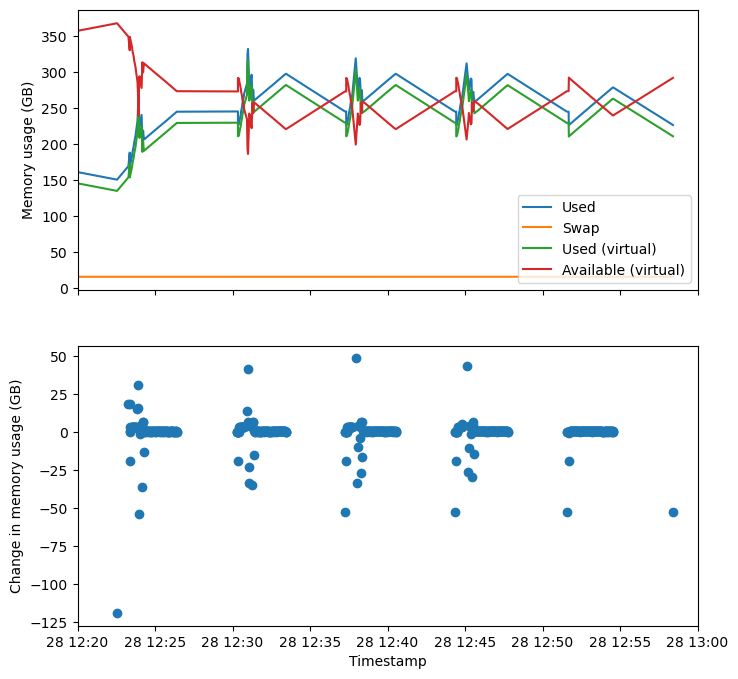

In [30]:
f,ax = job.plot_memory_usage()
plt.xlim(x0,x1)
